<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/Compute_effect_matched_spatial_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 3.7 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import EMS, compute_ems
from sklearn.model_selection import StratifiedKFold

data_path = sample.data_path()

meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
event_fname = meg_path / 'sample_audvis_filt-0-40_raw-eve.fif'
event_ids = {'AudL': 1, 'VisL': 3}

raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(0.5, 45, fir_design='firwin')
events = mne.read_events(event_fname)

picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=True,
                       exclude='bads')

epochs = mne.Epochs(raw, events, event_ids, tmin=-0.2, tmax=0.5, picks=picks,
                    baseline=None, reject=dict(grad=4000e-13, eog=150e-6),
                    preload=True)
epochs.drop_bad()
epochs.pick_types(meg='grad')


Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 916GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62

Number of events,123
Events,AudL: 56VisL: 67
Time range,-0.200 – 0.499 sec
Baseline,off


In [16]:
X=epochs.get_data()
y=epochs.events[:,2]
n_epochs,n_channels,n_times=X.shape
X.shape

(123, 203, 106)

In [17]:
ems=EMS
X_transform=np.zeros((n_epochs,n_times))
filters=list()


In [28]:
for train, test in StratifiedKFold(n_splits=5).split(X, y):

  X_scaled=X/np.std(X[train])
  ems.fit(ems,X_scaled[train],y[train])
  filters.append(ems.filters_)

  X_transform[test]=ems.transform(ems,X_scaled[test])
  
filters=np.mean(filters,axis=0)



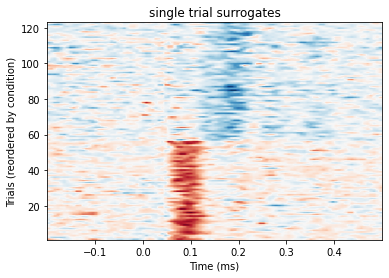

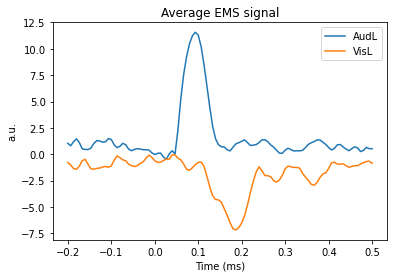

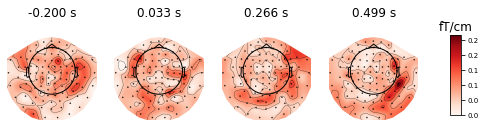

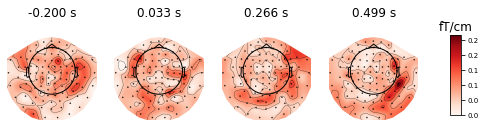

In [30]:
plt.figure()
plt.title('single trial surrogates')
plt.imshow(X_transform[y.argsort()], origin='lower', aspect='auto',
           extent=[epochs.times[0], epochs.times[-1], 1, len(X_transform)],
           cmap='RdBu_r')
plt.xlabel('Time (ms)')
plt.ylabel('Trials (reordered by condition)')

plt.figure()
plt.title('Average EMS signal')
mappings = [(key, value) for key, value in event_ids.items()]
for key, value in mappings:
    ems_ave = X_transform[y == value]
    plt.plot(epochs.times, ems_ave.mean(0), label=key)
plt.xlabel('Time (ms)')
plt.ylabel('a.u.')
plt.legend(loc='best')
plt.show()

evoked = EvokedArray(filters, epochs.info, tmin=epochs.tmin)
evoked.plot_topomap(time_unit='s', scalings=1)

In [31]:
epochs.equalize_event_counts(event_ids)
X_transform, filters, classes = compute_ems(epochs)

Dropped 11 epochs: 26, 47, 66, 75, 76, 79, 80, 81, 100, 103, 108
...computing surrogate time series. This can take some time
